<a href="https://colab.research.google.com/github/kaiju-no-9/Pytorch-Notes-/blob/main/Copy_of_class_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Class 6: Building & Training a Modern LLM
## From scratch — RMSNorm, SwiGLU, RoPE, GQA

---

## Section 0: Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import time
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
# macbook : "mps"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Section 0.1: Download & Prepare Shakespeare

In [ ]:
# Download the tiny-shakespeare dataset
DATA_URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

if not os.path.exists("shakespeare.txt"):
    import urllib.request
    urllib.request.urlretrieve(DATA_URL, "shakespeare.txt")

with open("shakespeare.txt", "r") as f:
    text = f.read()

print(f"Total characters: {len(text):,}")
print(f"First 200 characters:\n{text[:200]}")

Total characters: 1,115,394
First 200 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


# charcter level tokenization

---

TODO:
- use and implement BPE (Byte Pair Encoding)



In [ ]:
# Build character vocabulary
chars = sorted(set(text))
vocab_size = len(chars)

# Character <-> Integer mappings
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}

# Encode/decode helpers
def encode(s):
    return [char_to_idx[c] for c in s]

def decode(ids):
    return "".join([idx_to_char[i] for i in ids])

print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {''.join(chars)}")
print(f"\nExample encoding:")
print(f"  'Hello' -> {encode('Hello')}")
print(f"  {encode('Hello')} -> '{decode(encode('Hello'))}'")

Vocabulary size: 65
Characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Example encoding:
  'Hello' -> [20, 43, 50, 50, 53]
  [20, 43, 50, 50, 53] -> 'Hello'


In [ ]:
# Train/val split (90/10)
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"Training tokens:   {len(train_data):,}")
print(f"Validation tokens: {len(val_data):,}")

Training tokens:   1,003,854
Validation tokens: 111,540


In [ ]:
# Batching: grab random chunks of text
def get_batch(split, batch_size, context_length):
    d = train_data if split == "train" else val_data
    ix = torch.randint(len(d) - context_length, (batch_size,))
    x = torch.stack([d[i:i+context_length] for i in ix])
    y = torch.stack([d[i+1:i+context_length+1] for i in ix])
    return x.to(device), y.to(device)

# Quick test
xb, yb = get_batch("train", batch_size=4, context_length=8)
print(f"Input shape:  {xb.shape}  (batch_size x context_length)")
print(f"Target shape: {yb.shape}")
print(f"\nExample (first sequence):")
print(f"  Input:  {decode(xb[0].tolist())!r}")
print(f"  Target: {decode(yb[0].tolist())!r}")
print(f"  (Target is input shifted by 1 character)")

Input shape:  torch.Size([4, 8])  (batch_size x context_length)
Target shape: torch.Size([4, 8])

Example (first sequence):
  Input:  's his re'
  Target: ' his rea'
  (Target is input shifted by 1 character)


---
# Section 1: RMSNorm

**What you know:** LayerNorm subtracts mean, divides by std, then scales and shifts.

**The upgrade:** RMSNorm skips the mean subtraction and the shift. Just divide by the root-mean-square, then scale. Simpler, faster, works just as well.

In [ ]:
class RMSNorm(nn.Module):
    """
    Root Mean Square Layer Normalization.

    Simpler than LayerNorm:
    - No mean subtraction
    - No bias/shift parameter
    - Just: x / RMS(x) * learnable_scale
    """
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        return (x / rms) * self.weight

# We will also use Dropout throughout the model.
# Dropout randomly zeroes some values during training,
# forcing the model to not rely on any single feature.
# This prevents memorization (overfitting).
DROPOUT = 0.2


# --- Demo ---
demo_x = torch.randn(2, 4, 8)
norm = RMSNorm(8)
demo_out = norm(demo_x)

print("RMSNorm demo:")
print(f"  Input  - mean: {demo_x.mean():.3f}, std: {demo_x.std():.3f}")
print(f"  Output - mean: {demo_out.mean():.3f}, std: {demo_out.std():.3f}")
print(f"  Input range:  [{demo_x.min():.3f}, {demo_x.max():.3f}]")
print(f"  Output range: [{demo_out.min():.3f}, {demo_out.max():.3f}]")
print(f"\n  Parameters: just a scale vector of size {norm.weight.shape}")

RMSNorm demo:
  Input  - mean: -0.015, std: 1.004
  Output - mean: -0.000, std: 1.008
  Input range:  [-2.829, 2.391]
  Output range: [-2.168, 2.031]

  Parameters: just a scale vector of size torch.Size([8])


---
# Section 2: Rotary Positional Embeddings (RoPE)

**What you know:** Sinusoidal positional encoding — add a fixed pattern to embeddings.

**The upgrade:** RoPE *rotates* Q and K vectors based on position. The dot product then naturally captures *relative* distance between tokens.

Like a clock: the angle between 3 o'clock and 5 o'clock = the angle between 7 o'clock and 9 o'clock. Absolute position doesn't matter, only the gap.

In [ ]:
def precompute_rope_freqs(head_dim, max_seq_len, base=10000.0):
    """
    Precompute cosine and sine tables for RoPE.

    Each pair of dimensions gets a different rotation frequency.
    Low dims  -> fast rotation -> short-range patterns
    High dims -> slow rotation -> long-range patterns
    """
    freqs = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
    positions = torch.arange(max_seq_len).float()
    angles = torch.outer(positions, freqs)  # [max_seq_len, head_dim // 2]
    return torch.cos(angles), torch.sin(angles)


def apply_rope(x, cos, sin):
    """
    Apply rotary embeddings to a tensor.

    x: [batch, n_heads, seq_len, head_dim]
    cos, sin: [seq_len, head_dim // 2]

    For each pair of dimensions (2i, 2i+1):
      rotated_2i   = x_2i * cos - x_2i+1 * sin
      rotated_2i+1 = x_2i * sin + x_2i+1 * cos
    """
    seq_len = x.shape[2]
    cos = cos[:seq_len].unsqueeze(0).unsqueeze(0)  # [1, 1, seq, hd//2]
    sin = sin[:seq_len].unsqueeze(0).unsqueeze(0)

    x1 = x[..., ::2]   # even dims
    x2 = x[..., 1::2]  # odd dims

    out1 = x1 * cos - x2 * sin
    out2 = x1 * sin + x2 * cos

    return torch.stack([out1, out2], dim=-1).flatten(-2)

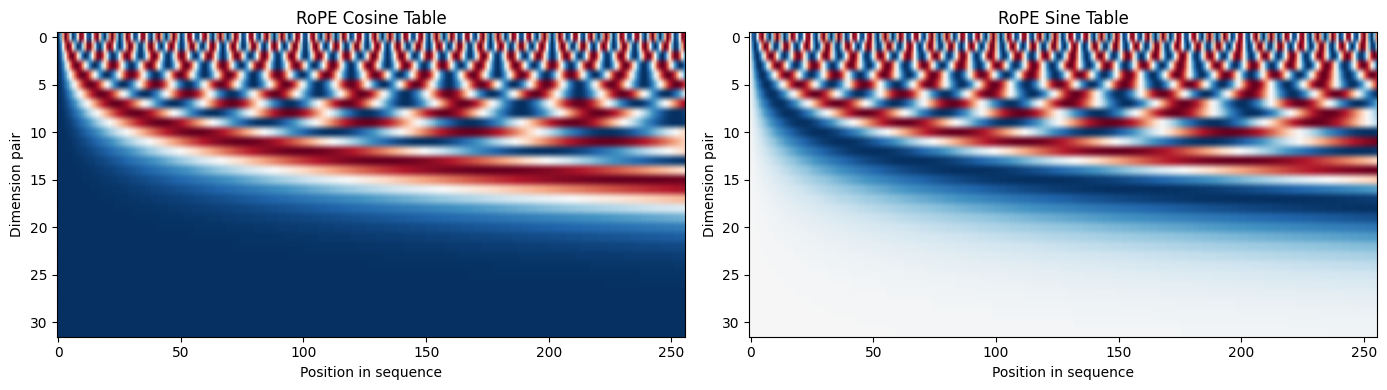

Low dimension pairs (top rows)  -> fast oscillation -> short-range patterns
High dimension pairs (bottom rows) -> slow oscillation -> long-range patterns


In [ ]:
# --- Visualize the rotation frequencies ---
demo_cos, demo_sin = precompute_rope_freqs(head_dim=64, max_seq_len=256)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].imshow(demo_cos.T.numpy(), aspect="auto", cmap="RdBu", vmin=-1, vmax=1)
axes[0].set_xlabel("Position in sequence")
axes[0].set_ylabel("Dimension pair")
axes[0].set_title("RoPE Cosine Table")

axes[1].imshow(demo_sin.T.numpy(), aspect="auto", cmap="RdBu", vmin=-1, vmax=1)
axes[1].set_xlabel("Position in sequence")
axes[1].set_ylabel("Dimension pair")
axes[1].set_title("RoPE Sine Table")

plt.tight_layout()
plt.show()

print("Low dimension pairs (top rows)  -> fast oscillation -> short-range patterns")
print("High dimension pairs (bottom rows) -> slow oscillation -> long-range patterns")

---
# Section 3: Grouped Query Attention (GQA)

**What you know:** Multi-Head Attention — each head has its own Q, K, V.

**The upgrade:** GQA uses fewer K,V heads than Q heads. Groups of query heads *share* key-value pairs. Same quality, much less memory for the KV cache.

In [ ]:
def repeat_kv(x, n_rep):
    """
    Repeat KV heads to match the number of query heads.
    x: [batch, n_kv_heads, seq_len, head_dim]
    Returns: [batch, n_kv_heads * n_rep, seq_len, head_dim]
    """
    if n_rep == 1:
        return x
    b, n_kv, seq, hd = x.shape
    return (x[:, :, None, :, :]
            .expand(b, n_kv, n_rep, seq, hd)
            .reshape(b, n_kv * n_rep, seq, hd))


class GroupedQueryAttention(nn.Module):
    """
    Grouped Query Attention with RoPE.
    n_heads query heads, n_kv_heads key/value heads.
    Groups of (n_heads // n_kv_heads) query heads share one KV pair.
    """
    def __init__(self, d_model, n_heads, n_kv_heads):
        super().__init__()
        assert d_model % n_heads == 0
        assert n_heads % n_kv_heads == 0

        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_heads // n_kv_heads
        self.head_dim = d_model // n_heads

        self.q_proj = nn.Linear(d_model, n_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(d_model, n_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(d_model, n_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(n_heads * self.head_dim, d_model, bias=False)

    def forward(self, x, rope_cos, rope_sin):
        b, seq, _ = x.shape

        # Project Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # Reshape into heads
        q = q.view(b, seq, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(b, seq, self.n_kv_heads, self.head_dim).transpose(1, 2)
        v = v.view(b, seq, self.n_kv_heads, self.head_dim).transpose(1, 2)

        # Apply RoPE to Q and K (not V!)
        q = apply_rope(q, rope_cos, rope_sin)
        k = apply_rope(k, rope_cos, rope_sin)

        # Repeat KV heads to match Q heads
        k = repeat_kv(k, self.n_rep)
        v = repeat_kv(v, self.n_rep)

        # Scaled dot-product attention with causal mask
        scale = 1.0 / math.sqrt(self.head_dim)
        scores = (q @ k.transpose(-2, -1)) * scale

        mask = torch.triu(torch.ones(seq, seq, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float("-inf"))

        weights = F.softmax(scores, dim=-1)

        # Dropout on attention weights (regularization)
        weights = F.dropout(weights, p=DROPOUT, training=self.training)

        out = weights @ v

        # Merge heads and project
        out = out.transpose(1, 2).contiguous().view(b, seq, -1)
        return self.o_proj(out)

In [ ]:
# --- Demo: see GQA shapes ---
print("GQA Shape Demo:")
print(f"  Config: d_model=256, n_heads=8, n_kv_heads=2")
print(f"  -> head_dim = 256/8 = 32")
print(f"  -> 8 Q heads, 2 KV heads")
print(f"  -> each KV head shared by 4 Q heads\n")

demo_gqa = GroupedQueryAttention(d_model=256, n_heads=8, n_kv_heads=2).to(device)
demo_cos, demo_sin = precompute_rope_freqs(head_dim=32, max_seq_len=128)
demo_cos, demo_sin = demo_cos.to(device), demo_sin.to(device)

demo_in = torch.randn(2, 16, 256, device=device)
demo_out = demo_gqa(demo_in, demo_cos, demo_sin)
print(f"  Input:  {demo_in.shape}")
print(f"  Output: {demo_out.shape}")

q_params = 256 * (8 * 32)
kv_params = 256 * (2 * 32) * 2
print(f"\n  Q projection params:  {q_params:,}  (full 8 heads)")
print(f"  KV projection params: {kv_params:,}  (only 2 heads)")
print(f"  KV cache savings: {8//2}x smaller than standard MHA!")

GQA Shape Demo:
  Config: d_model=256, n_heads=8, n_kv_heads=2
  -> head_dim = 256/8 = 32
  -> 8 Q heads, 2 KV heads
  -> each KV head shared by 4 Q heads

  Input:  torch.Size([2, 16, 256])
  Output: torch.Size([2, 16, 256])

  Q projection params:  65,536  (full 8 heads)
  KV projection params: 32,768  (only 2 heads)
  KV cache savings: 4x smaller than standard MHA!


---
# Section 4: SwiGLU Feed-Forward Network

**What you know:** FFN = expand -> ReLU -> contract.

**The upgrade:** SwiGLU splits into two paths — a *gate* that decides how much info flows through, and a *value* path that carries the info. They combine via element-wise multiplication.

In [ ]:
class SwiGLU(nn.Module):
    """
    SwiGLU Feed-Forward Network.

    Two paths:
      gate: SiLU(x @ W_gate) - controls flow
      up:   x @ W_up         - carries information

    Combined: gate * up -> W_down

    SiLU(x) = x * sigmoid(x), a smooth version of ReLU.
    """
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.w_gate = nn.Linear(d_model, hidden_dim, bias=False)
        self.w_up   = nn.Linear(d_model, hidden_dim, bias=False)
        self.w_down = nn.Linear(hidden_dim, d_model, bias=False)

    def forward(self, x):
        gate = F.silu(self.w_gate(x))
        up   = self.w_up(x)
        return F.dropout(self.w_down(gate * up), p=DROPOUT, training=self.training)

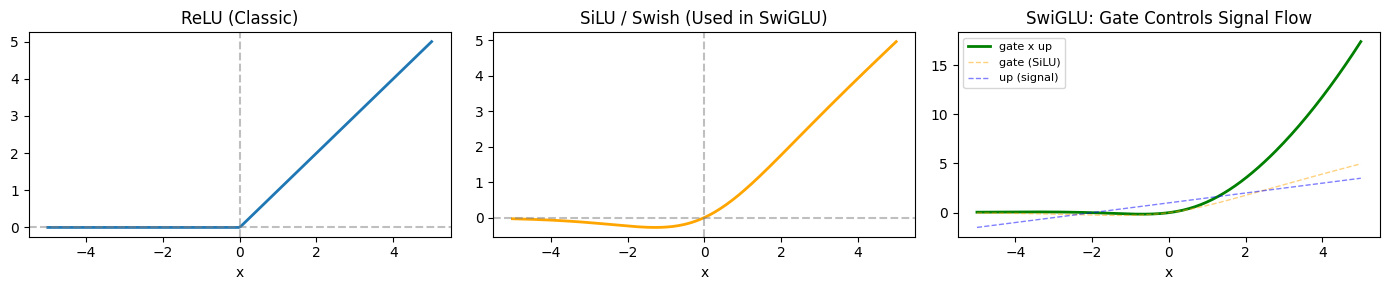

Key insight: SiLU is smooth unlike ReLU's hard cutoff at 0.
The gating mechanism lets the network LEARN which dimensions to keep.


In [ ]:
# --- Demo: Compare activation functions ---
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

x_range = torch.linspace(-5, 5, 200)

axes[0].plot(x_range, F.relu(x_range), linewidth=2)
axes[0].set_title("ReLU (Classic)")
axes[0].set_xlabel("x")
axes[0].axhline(y=0, color="gray", linestyle="--", alpha=0.5)
axes[0].axvline(x=0, color="gray", linestyle="--", alpha=0.5)

axes[1].plot(x_range, F.silu(x_range), linewidth=2, color="orange")
axes[1].set_title("SiLU / Swish (Used in SwiGLU)")
axes[1].set_xlabel("x")
axes[1].axhline(y=0, color="gray", linestyle="--", alpha=0.5)
axes[1].axvline(x=0, color="gray", linestyle="--", alpha=0.5)

gate_demo = F.silu(x_range)
up_demo = x_range * 0.5 + 1
axes[2].plot(x_range, gate_demo * up_demo, linewidth=2, color="green", label="gate x up")
axes[2].plot(x_range, gate_demo, linewidth=1, color="orange", alpha=0.5, linestyle="--", label="gate (SiLU)")
axes[2].plot(x_range, up_demo, linewidth=1, color="blue", alpha=0.5, linestyle="--", label="up (signal)")
axes[2].set_title("SwiGLU: Gate Controls Signal Flow")
axes[2].set_xlabel("x")
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()

print("Key insight: SiLU is smooth unlike ReLU's hard cutoff at 0.")
print("The gating mechanism lets the network LEARN which dimensions to keep.")

---
# Section 5: Assemble the Full Model

Now we wire everything together:
1. Token Embedding
2. N x Transformer Blocks (RMSNorm -> GQA -> Add -> RMSNorm -> SwiGLU -> Add)
3. Final RMSNorm -> Language Model Head

In [ ]:
class TransformerBlock(nn.Module):
    """
    One layer of a modern transformer.

    Pre-norm architecture:
      x -> RMSNorm -> GQA Attention -> + residual
      x -> RMSNorm -> SwiGLU FFN     -> + residual
    """
    def __init__(self, d_model, n_heads, n_kv_heads, ffn_hidden_dim):
        super().__init__()
        self.attn_norm = RMSNorm(d_model)
        self.attention = GroupedQueryAttention(d_model, n_heads, n_kv_heads)
        self.ffn_norm  = RMSNorm(d_model)
        self.ffn       = SwiGLU(d_model, ffn_hidden_dim)

    def forward(self, x, rope_cos, rope_sin):
        # Pre-norm -> Attention -> Residual
        x = x + self.attention(self.attn_norm(x), rope_cos, rope_sin)
        # Pre-norm -> FFN -> Residual
        x = x + self.ffn(self.ffn_norm(x))
        return x

In [ ]:

class MiniLLM(nn.Module):
    """
    A small but modern language model.

    Architecture: modern transformer with all 4 upgrades.
    Training objective: next character prediction.
    """
    def __init__(self, vocab_size, d_model, n_layers, n_heads, n_kv_heads,
                 ffn_hidden_dim, max_seq_len):
        super().__init__()

        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # Token embedding (no positional embedding -- RoPE handles position)
        self.token_emb = nn.Embedding(vocab_size, d_model)

        # Transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, n_kv_heads, ffn_hidden_dim)
            for _ in range(n_layers)
        ])

        # Final norm and output head
        self.final_norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # Weight tying: share embedding and output weights
        self.lm_head.weight = self.token_emb.weight

        # Precompute RoPE frequencies
        head_dim = d_model // n_heads
        rope_cos, rope_sin = precompute_rope_freqs(head_dim, max_seq_len)
        self.register_buffer("rope_cos", rope_cos)
        self.register_buffer("rope_sin", rope_sin)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        b, seq_len = idx.shape

        # Token embedding
        x = self.token_emb(idx)

        # Pass through transformer blocks
        for layer in self.layers:
            x = layer(x, self.rope_cos, self.rope_sin)

        # Final norm + project to vocabulary
        x = self.final_norm(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1)
            )

        return logits, loss

## 5.1: Create the model and inspect it

In [ ]:
# --- Model Configuration ---

config = {
    "vocab_size":     vocab_size,
    "d_model":        256,
    "n_layers":       4,
    "n_heads":        8,
    "n_kv_heads":     2,
    "ffn_hidden_dim": 680,
    "max_seq_len":    256,
}

model = MiniLLM(**config).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 50)
print("  MODEL SUMMARY")
print("=" * 50)
print(f"  Vocabulary:      {config['vocab_size']}")
print(f"  Embedding dim:   {config['d_model']}")
print(f"  Layers:          {config['n_layers']}")
print(f"  Query heads:     {config['n_heads']}")
print(f"  KV heads:        {config['n_kv_heads']} (GQA ratio: {config['n_heads']//config['n_kv_heads']}:1)")
print(f"  FFN hidden dim:  {config['ffn_hidden_dim']}")
print(f"  Context length:  {config['max_seq_len']}")
print(f"  Head dim:        {config['d_model'] // config['n_heads']}")
print(f"{'=' * 50}")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size (approx):  {total_params * 4 / 1e6:.1f} MB (float32)")
print(f"{'=' * 50}")

  MODEL SUMMARY
  Vocabulary:      65
  Embedding dim:   256
  Layers:          4
  Query heads:     8
  KV heads:        2 (GQA ratio: 4:1)
  FFN hidden dim:  680
  Context length:  256
  Head dim:        32
  Total parameters:     2,763,264
  Trainable parameters: 2,763,264
  Model size (approx):  11.1 MB (float32)



# Section 6: Training

Same training loop pattern from Class 2 — forward, loss, backward, step. The model inside is more sophisticated, but the dance is identical.

In [ ]:
# --- Training Hyperparameters ---
BATCH_SIZE = 64
CONTEXT_LEN = config["max_seq_len"]
LEARNING_RATE = 3e-4
MAX_STEPS = 3000
EVAL_INTERVAL = 250
EVAL_STEPS = 20
LOG_INTERVAL = 50

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
@torch.no_grad()
def estimate_loss():
    """Estimate loss on train and val splits."""
    model.eval()
    out = {}
    for split in ["train", "val"]:
        losses = []
        for _ in range(EVAL_STEPS):
            xb, yb = get_batch(split, BATCH_SIZE, CONTEXT_LEN)
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out

In [ ]:
# --- Training Loop ---
print("Starting training...")
print(f"  {MAX_STEPS} steps, batch_size={BATCH_SIZE}, context_len={CONTEXT_LEN}")
print(f"  Evaluating every {EVAL_INTERVAL} steps")
print("-" * 60)

train_losses = []
val_losses = []
step_log = []
start_time = time.time()

model.train()
for step in range(MAX_STEPS):
    xb, yb = get_batch("train", BATCH_SIZE, CONTEXT_LEN)

    logits, loss = model(xb, yb)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    if step % LOG_INTERVAL == 0:
        elapsed = time.time() - start_time
        print(f"  Step {step:5d}/{MAX_STEPS} | Loss: {loss.item():.4f} | Time: {elapsed:.0f}s")

    if step % EVAL_INTERVAL == 0 or step == MAX_STEPS - 1:
        losses = estimate_loss()
        train_losses.append(losses["train"])
        val_losses.append(losses["val"])
        step_log.append(step)
        if step > 0:
            elapsed = time.time() - start_time
            steps_per_sec = step / elapsed
            remaining = (MAX_STEPS - step) / steps_per_sec
            print(f"  >>> Eval @ step {step}: train={losses['train']:.4f}, val={losses['val']:.4f} | ~{remaining:.0f}s remaining")

total_time = time.time() - start_time
print("-" * 60)
print(f"Training complete! Total time: {total_time:.0f}s ({total_time/60:.1f} min)")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss:   {val_losses[-1]:.4f}")

Starting training...
  3000 steps, batch_size=64, context_len=256
  Evaluating every 250 steps
------------------------------------------------------------
  Step     0/3000 | Loss: 4.2273 | Time: 1s
  Step    50/3000 | Loss: 2.5231 | Time: 14s
  Step   100/3000 | Loss: 2.1859 | Time: 25s
  Step   150/3000 | Loss: 1.9731 | Time: 36s
  Step   200/3000 | Loss: 1.8248 | Time: 46s
  Step   250/3000 | Loss: 1.6646 | Time: 57s
  >>> Eval @ step 250: train=1.6231, val=1.7724 | ~659s remaining
  Step   300/3000 | Loss: 1.6127 | Time: 70s
  Step   350/3000 | Loss: 1.5919 | Time: 81s
  Step   400/3000 | Loss: 1.4941 | Time: 91s
  Step   450/3000 | Loss: 1.5076 | Time: 102s
  Step   500/3000 | Loss: 1.4546 | Time: 113s
  >>> Eval @ step 500: train=1.3927, val=1.6053 | ~579s remaining
  Step   550/3000 | Loss: 1.4378 | Time: 126s
  Step   600/3000 | Loss: 1.4283 | Time: 137s
  Step   650/3000 | Loss: 1.4278 | Time: 147s
  Step   700/3000 | Loss: 1.3771 | Time: 158s
  Step   750/3000 | Loss: 1.3785

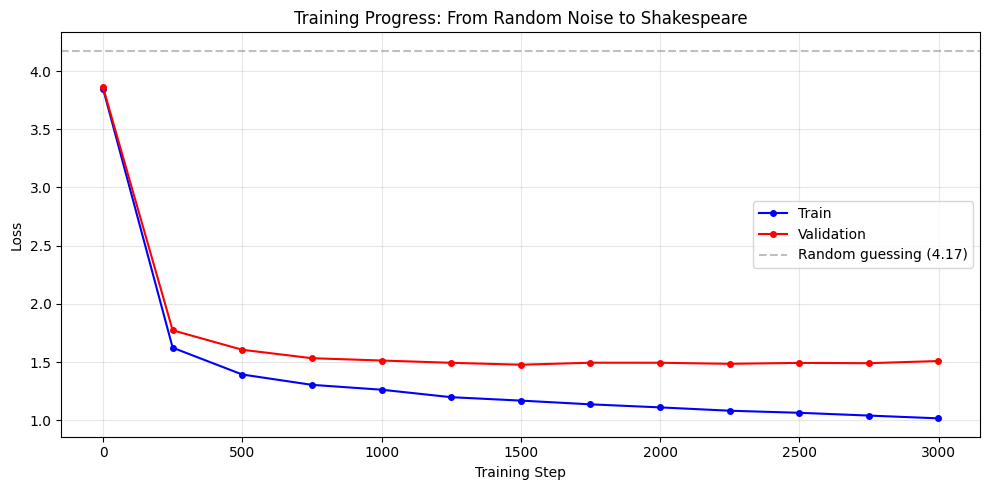

In [ ]:
# --- Plot Loss Curve ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(step_log, train_losses, "b-o", label="Train", markersize=4)
ax.plot(step_log, val_losses, "r-o", label="Validation", markersize=4)
ax.axhline(y=math.log(vocab_size), color="gray", linestyle="--", alpha=0.5,
           label=f"Random guessing ({math.log(vocab_size):.2f})")
ax.set_xlabel("Training Step")
ax.set_ylabel("Loss")
ax.set_title("Training Progress: From Random Noise to Shakespeare")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# Section 7: Generate Text! 🎭

The payoff. We feed in a seed text, predict the next character, append it, and repeat. This is **autoregressive generation** — the same process ChatGPT uses, just at character level.

In [ ]:
@torch.no_grad()
def generate(model, prompt, max_new_tokens=500, temperature=0.8):
    """
    Generate text autoregressively.

    temperature controls randomness:
      low (0.3)  -> conservative, repetitive
      mid (0.8)  -> balanced
      high (1.2) -> creative, chaotic
    """
    model.eval()
    tokens = encode(prompt)
    tokens = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):
        context = tokens[:, -config["max_seq_len"]:]
        logits, _ = model(context)
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, next_token], dim=1)

    return decode(tokens[0].tolist())

In [ ]:
# --- Generate at different temperatures ---
prompt = "ROMEO:"

print("=" * 60)
print(f"  PROMPT: {prompt!r}")
print("=" * 60)

for temp in [0.5, 0.8, 1.0, 1.2]:
    print(f"\n{'_' * 60}")
    print(f"  Temperature = {temp}")
    print(f"{'_' * 60}")
    output = generate(model, prompt, max_new_tokens=300, temperature=temp)
    print(output)

  PROMPT: 'ROMEO:'

____________________________________________________________
  Temperature = 0.5
____________________________________________________________
ROMEO:
That she is come to me at once so strength
To shake the contrary of the most dead.

ROMEO:
I think the lady for the morning of the world.

JULIET:
Thy best conspiracy did I see thee to my son,
To make a man be more than thou hast done.

ROMEO:
My lord, I will be so, thou hast a son.

Nurse:
And to 

____________________________________________________________
  Temperature = 0.8
____________________________________________________________
ROMEO:
Or if I am a pace, and fain and dream
Have I been dead; but queen abhorred head
Makes me of the jewel.

Nurse:
My lord, I say; I'll give a fool and tell me what:
if they would have needed to the given me them,
carried up on their hearts and drums,
And not among them and in the dancing eyes,
And wil

____________________________________________________________
  Temperature = 1.0

In [ ]:
# --- Try different prompts ---
prompts = [
    "RISHABH:",
]

for p in prompts:
    print(f"\n{'=' * 60}")
    print(f"  PROMPT: {p!r}")
    print(f"{'=' * 60}")
    output = generate(model, p, max_new_tokens=200, temperature=0.8)
    print(output)


  PROMPT: 'RISHABH:'
RISHABH:
O if a horse! Will you think the same;
And therefore I'll speak it, and you may,
That you must say theregrow in the man.

HENRY BOLINGBROKE:
You must be all?

HENRY BOLINGBROKE:
No, grief, go with me


---
# Section 8: Experiments (Try These!)

Now that you have a working model, explore:

1. **Temperature sweep:** Generate the same prompt at temperatures 0.1, 0.5, 1.0, 1.5, 2.0. What happens at extremes?
2. **Model surgery:** Print weight shapes and spot the GQA difference.
3. **Scaling question:** What would happen if you doubled `d_model`? (Think about it before trying!)

In [ ]:
# Experiment 1: Temperature sweep
prompt = "HAMLET:\nTo be"
print("Temperature sweep on the same prompt:\n")
for temp in [0.1, 0.3, 0.5, 0.8, 1.0, 1.5]:
    output = generate(model, prompt, max_new_tokens=100, temperature=temp)
    generated = output[len(prompt):]
    print(f"  T={temp:.1f}: {generated[:80]}...")
    print()

Temperature sweep on the same prompt:

  T=0.1:  so sweet son, and the seat of the world,
The senators of the court: the sea the...

  T=0.3:  so still and the seat of the court.

Second Murderer:
Have you done to the prin...

  T=0.5:  so still like some that of the world,
And for the war of the triumphant sea,
An...

  T=0.8:  but faith and leave it in him.

CAPULET:
Why, what a poor son?

Nurse:
You lie ...

  T=1.0:  all noticcond George Wiltship and Gremio;
And gave the trumpets length of joy!
...

  T=1.5: gin? it's little in a dumpets' times;
Thou, overhearted fully with a king.

ROME...



In [ ]:
# Experiment 2: See GQA in the weight shapes
print("GQA in the weights:\n")
layer = model.layers[0].attention
q_shape = layer.q_proj.weight.shape
k_shape = layer.k_proj.weight.shape
v_shape = layer.v_proj.weight.shape

print(f"  Q projection: {q_shape}")
print(f"  K projection: {k_shape}")
print(f"  V projection: {v_shape}")
print(f"\n  Q has {q_shape[0] / k_shape[0]:.0f}x more output dimensions than K and V!")
print(f"  -> KV cache is {config['n_heads']//config['n_kv_heads']}x smaller than standard MHA")

GQA in the weights:

  Q projection: torch.Size([256, 256])
  K projection: torch.Size([64, 256])
  V projection: torch.Size([64, 256])

  Q has 4x more output dimensions than K and V!
  -> KV cache is 4x smaller than standard MHA


#TODOS:

- train this for more parameters
- use different data
- go to harkirat's yt channel, scrape the transcripts of the last few videos, clean, arrange them.
- use and implement BPE (Byte Pair Encoding)